- https://console.anthropic.com/workbench
- https://docs.anthropic.com/claude/reference/getting-started-with-the-api
- https://github.com/anthropics/anthropic-sdk-python
- https://huggingface.co/spaces/Xenova/the-tokenizer-playground

In [1]:
! pip install -q trio trio-asyncio httpx python-dotenv

In [2]:
from dotenv import load_dotenv
from os import environ

# Need .env file with 'ANTHROPIC_API_KEY=...'
load_dotenv()

API_URL = 'https://api.anthropic.com/v1/messages'

HEADERS = {
    'x-api-key': environ['ANTHROPIC_API_KEY'],
    'anthropic-version': '2023-06-01',
    'content-type': 'application/json',
}

MODELS = {
    'OPUS': 'claude-3-opus-20240229',
    'SONNET': 'claude-3-sonnet-20240229',
    'HAIKU': 'claude-3-haiku-20240307'
    # 'claude-2.1',
    # 'claude-2.0',
    # 'claude-instant-1.2',
}

PAYLOAD_BASE = {
    'model': MODELS['HAIKU'],
    'max_tokens': 1024,
}

In [3]:
import httpx
import json

payload = PAYLOAD_BASE | {
    'messages': [
        {'role': 'user', 'content': 'Hello Claude!'}
    ]
}
response = httpx.post(API_URL, headers=HEADERS, json=payload)

print(json.dumps(response.json(), indent=4))


{
    "id": "msg_013DJSH6kKBZqDBjrGcs95pE",
    "type": "message",
    "role": "assistant",
    "content": [
        {
            "type": "text",
            "text": "Hello there! It's nice to meet you. How can I assist you today?"
        }
    ],
    "model": "claude-3-haiku-20240307",
    "stop_reason": "end_turn",
    "stop_sequence": null,
    "usage": {
        "input_tokens": 10,
        "output_tokens": 20
    }
}


In [4]:
payload = PAYLOAD_BASE | {
    'messages': [
        {'role': 'user', 'content': 'Make a joke using 5 words.'}
    ],
    'stream': True
}
with httpx.stream('POST', API_URL, headers=HEADERS, json=payload) as response:
    for chunk in response.iter_text():
        print('🟢' + chunk + '🛑', flush=True)

🟢event: message_start
data: {"type":"message_start","message":{"id":"msg_01DFQ4Swf8NhkhscEmq8jHa9","type":"message","role":"assistant","content":[],"model":"claude-3-haiku-20240307","stop_reason":null,"stop_sequence":null,"usage":{"input_tokens":16,"output_tokens":2}} }

🛑
🟢event: content_block_start
data: {"type":"content_block_start","index":0,"content_block":{"type":"text","text":""}          }

🛑
🟢event: ping
data: {"type": "ping"}

🛑
🟢event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":"Knocked"}        }

🛑
🟢event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" over"}}

🛑
🟢event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" the"} }

event: content_block_delta
data: {"type":"content_block_delta","index":0,"delta":{"type":"text_delta","text":" cl"}         }

🛑
🟢event: content_block_delta
data: {"type":"content_

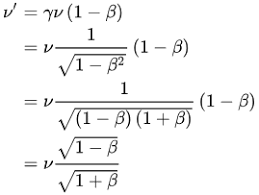

In [5]:
IMAGE_PATH = 'einstein.png'
TEXT = 'Give me the latex code for the formula in the image'

from IPython.display import Image
display(Image(filename=IMAGE_PATH))


🔹Image nBytes: 5420
{
  "type": "message_start",
  "message": {
    "id": "msg_0174e7wafGhrF9THsKn2yrCz",
    "type": "message",
    "role": "assistant",
    "content": [],
    "model": "claude-3-haiku-20240307",
    "stop_reason": null,
    "stop_sequence": null,
    "usage": {
      "input_tokens": 167,
      "output_tokens": 1
    }
  }
}
{
  "type": "content_block_start",
  "index": 0,
  "content_block": {
    "type": "text",
    "text": ""
  }
}
{
  "type": "ping"
}
{
  "type": "content_block_delta",
  "index": 0,
  "delta": {
    "type": "text_delta",
    "text": "The"
  }
}
{
  "type": "content_block_delta",
  "index": 0,
  "delta": {
    "type": "text_delta",
    "text": " La"
  }
}
{
  "type": "content_block_delta",
  "index": 0,
  "delta": {
    "type": "text_delta",
    "text": "TeX"
  }
}
{
  "type": "content_block_delta",
  "index": 0,
  "delta": {
    "type": "text_delta",
    "text": " code"
  }
}
{
  "type": "content_block_delta",
  "index": 0,
  "delta": {
    "type": 

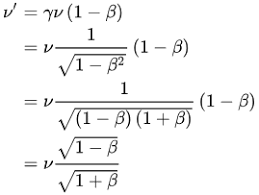

The LaTeX code for the formula in the image is:

$v' = \gamma v (1 - \beta) = \frac{v}{\sqrt{1 - \beta^2}} (1 - \beta) = \frac{v}{\sqrt{(1 - \beta)(1 + \beta)}} = v \sqrt{1 - \beta}$

In [7]:
import base64
import trio

from IPython.display import Markdown

def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

encoded_image = encode_image(IMAGE_PATH)

print(f'🔹Image nBytes: {len(encoded_image)}')

PAYLOAD = PAYLOAD_BASE | {
    'stream': True,
    'messages': [
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                    'source': {
                        'type': 'base64',
                        'media_type': 'image/png',
                        'data': encoded_image
                    }
                },
                {
                    'type': 'text',
                    'text': TEXT
                }
            ]
        }
    ]
}

async def stream_response(client):
    buffer = ''
    async with client.stream('POST', API_URL, headers=HEADERS, json=PAYLOAD, timeout=None) as response:
        async for chunk in response.aiter_text():
            buffer += chunk
            while '\n\n' in buffer:
                event, buffer = buffer.split('\n\n', 1)
                data_lines = [line.strip() for line in event.split('\n') if line.startswith('data:')]
                data = '\n'.join(data_lines[len('data: '):] for data_lines in data_lines)
                if data:
                    try:
                        event_data = json.loads(data)
                        yield event_data
                    except json.JSONDecodeError:
                        print('❌' + data)
                        continue

async def main():
    tokens_got = []

    async with httpx.AsyncClient() as client:
        async with trio.open_nursery() as nursery:
            async for event_data in stream_response(client):
                # Print the event data for debugging
                print(json.dumps(event_data, indent=2))

                # Check the event type
                if event_data['type'] == 'content_block_delta':
                    tokens_got.append(event_data['delta']['text'])

    reply = ''.join(tokens_got)
    print('🔸' + reply)
    display(Image(filename=IMAGE_PATH))
    display(Markdown(reply))


if __name__ == '__main__':
    trio.run(main)
